In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
pd.set_option("display.max_columns",None)


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import pyramid
from pmdarima.arima import auto_arima

In [2]:
data=pd.read_csv("monthly-milk-production-pounds-p.csv")

In [3]:
data.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [4]:
data.tail()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


#### Its a monthly data starting from year 1962 to 1975

In [5]:
data.drop(index=[168],inplace=True)

In [6]:
data.tail()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
163,1975-08,858.0
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0


In [7]:
data.rename(columns={"Monthly milk production: pounds per cow. Jan 62 ? Dec 75":"Monthly Milk Production: Pounds per Cow"},inplace=True)

In [8]:
data.head()

,Month,Monthly Milk Production: Pounds per Cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [9]:
data.dtypes

Month                                       object
Monthly Milk Production: Pounds per Cow    float64
dtype: object

In [10]:
data["Month"]=pd.to_datetime(data["Month"],infer_datetime_format=True)

In [11]:
data.dtypes

Month                                      datetime64[ns]
Monthly Milk Production: Pounds per Cow           float64
dtype: object

In [12]:
data.set_index("Month",inplace=True)

### Rolling Statistics and Dickey-Fuller Test (ADF)

In [13]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd =  timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.rcParams["figure.figsize"] = (18, 10)
    plt.xticks(rotation=90, ha='right')
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

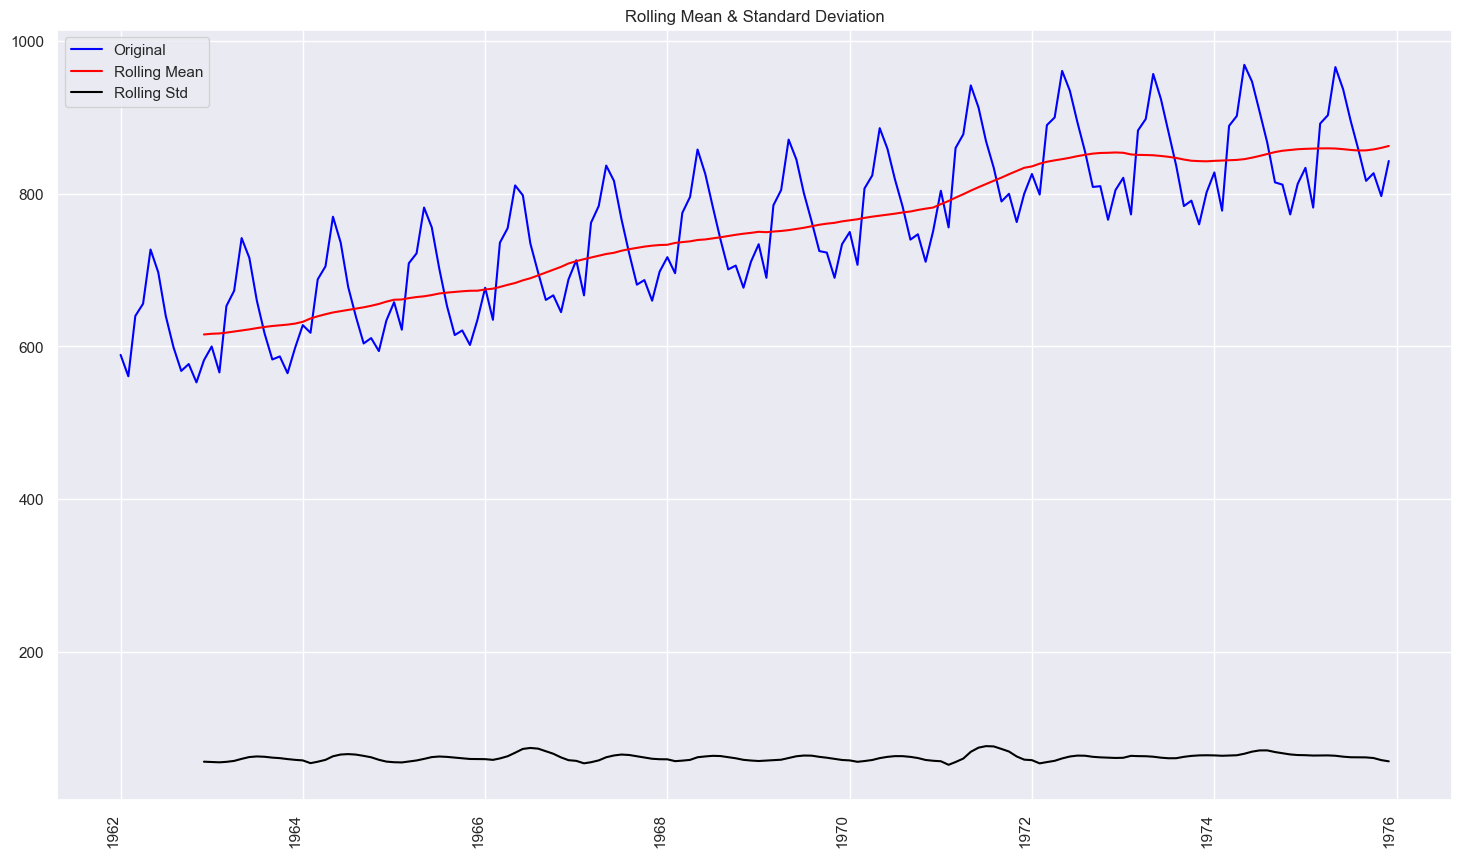

Results of Dickey-Fuller Test:
Test Statistic                  -1.303812
p-value                          0.627427
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


In [14]:
test_stationarity(data)

#### As p-value is greater than 0.05, we can accept the null hypothesis. So, this timeseries data is not stationary. We can also see Rolling mean is not constant which also proves timeseries is not stationary

### Logarthmic Transformation to make data stationary

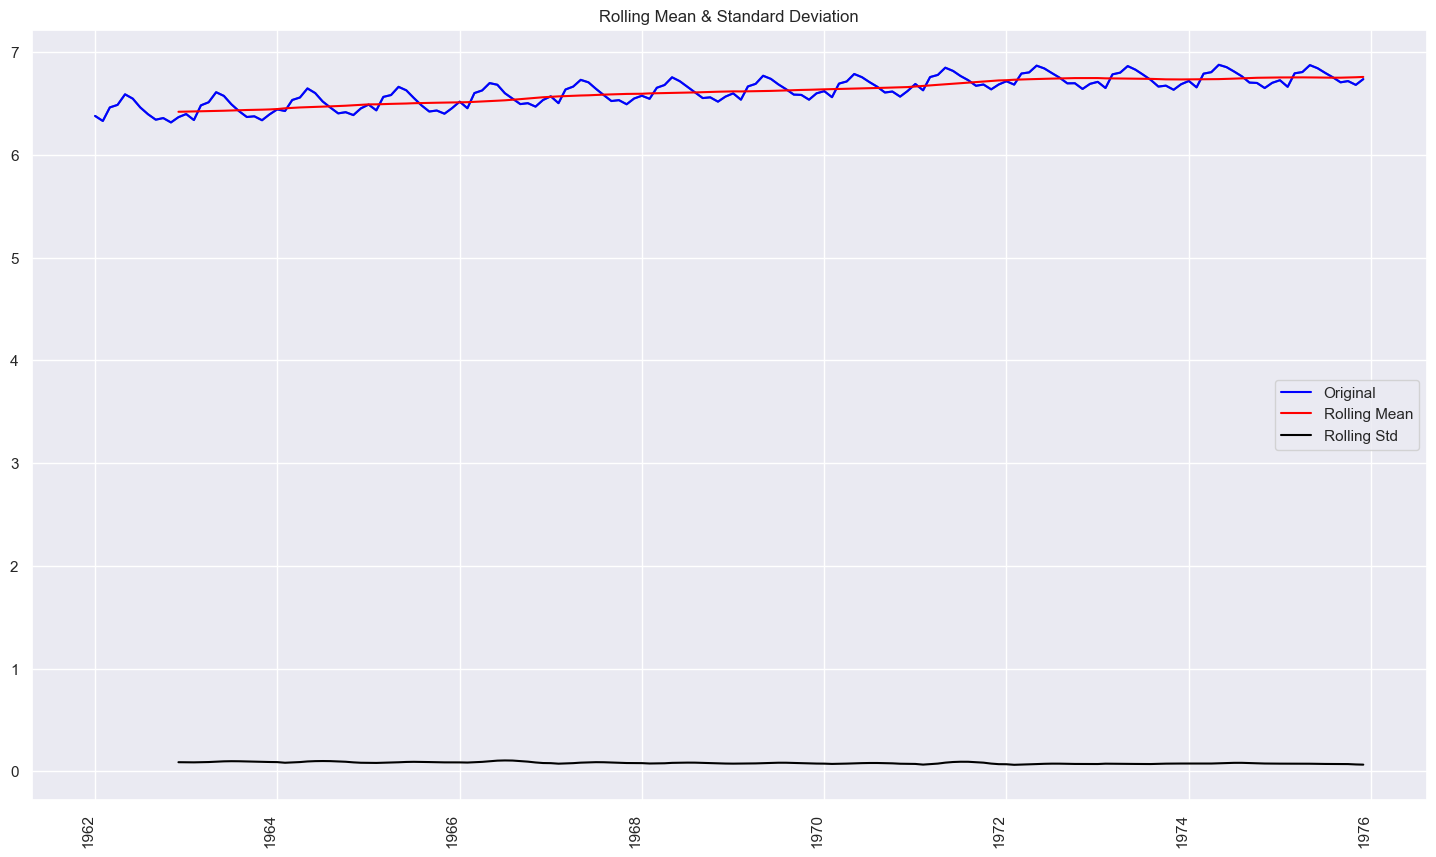

Results of Dickey-Fuller Test:
Test Statistic                  -1.754797
p-value                          0.403123
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


In [15]:
data_log = np.log(data)
plt.plot(data_log)
test_stationarity(data_log)

#### Still p-value is greater than 0.05

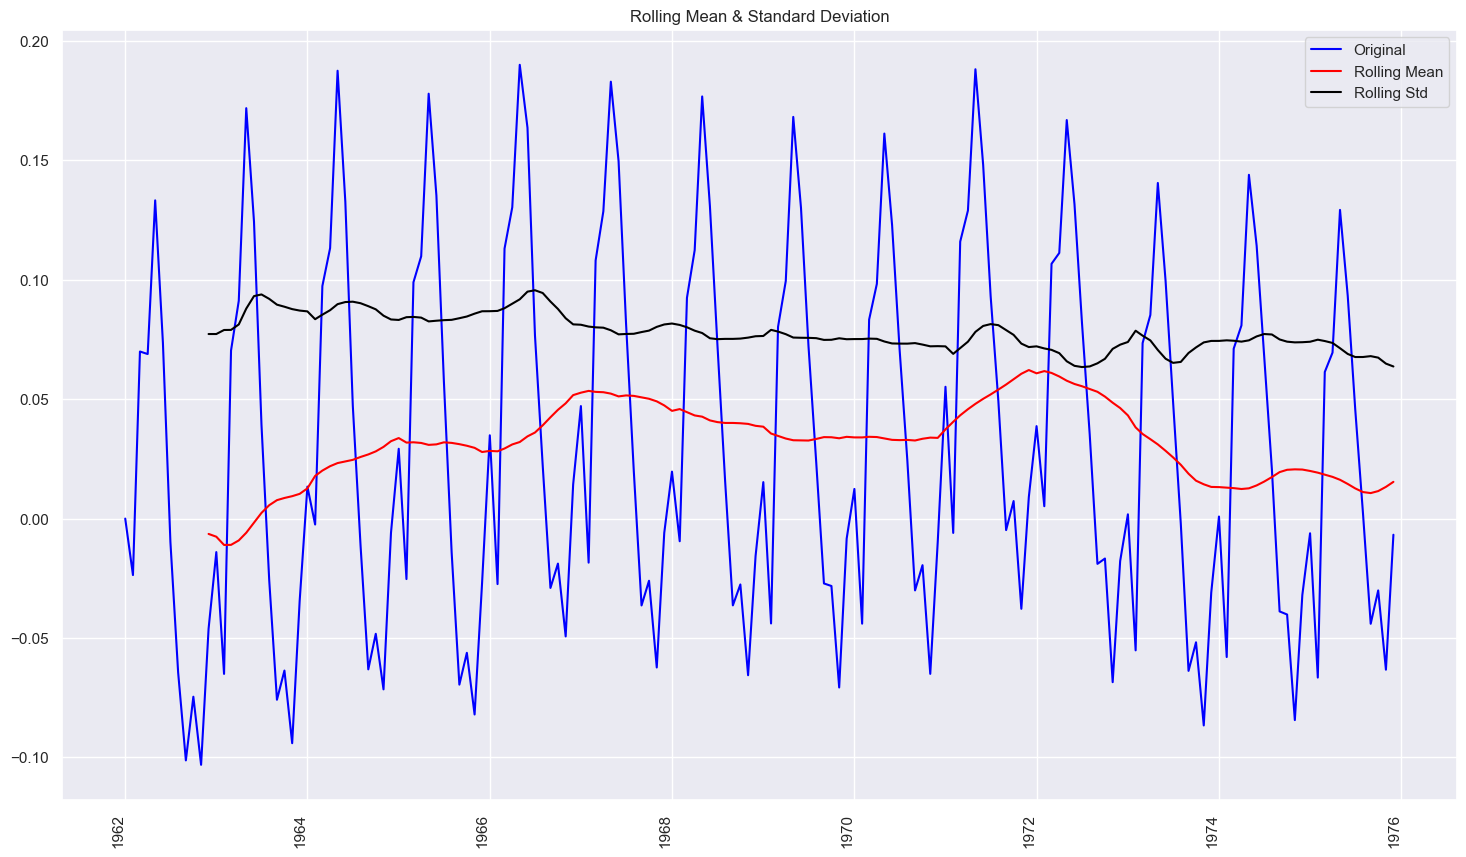

Results of Dickey-Fuller Test:
Test Statistic                  -3.869994
p-value                          0.002267
#Lags Used                      13.000000
Number of Observations Used    154.000000
Critical Value (1%)             -3.473543
Critical Value (5%)             -2.880498
Critical Value (10%)            -2.576878
dtype: float64


In [16]:
#Exponential weighted moving average
#Weights are assigned to all the previous values with a decay factor
#More recent values are given a higher weight
expwighted_avg =data_log.ewm(halflife=12).mean()
#plt.plot(data_log)
#plt.plot(expwighted_avg, color='red')
#Subtract rolling from original series
data_log_ewma_diff = data_log - expwighted_avg
#Test Stationarity
test_stationarity(data_log_ewma_diff)

#### Now p-value is less than 0.05, we can reject the null hypothesis and accept the alternate hypothesis. So, this timeseries data jas now become stationary.

### Decomposing data into Trend, Seasonality and Residuals

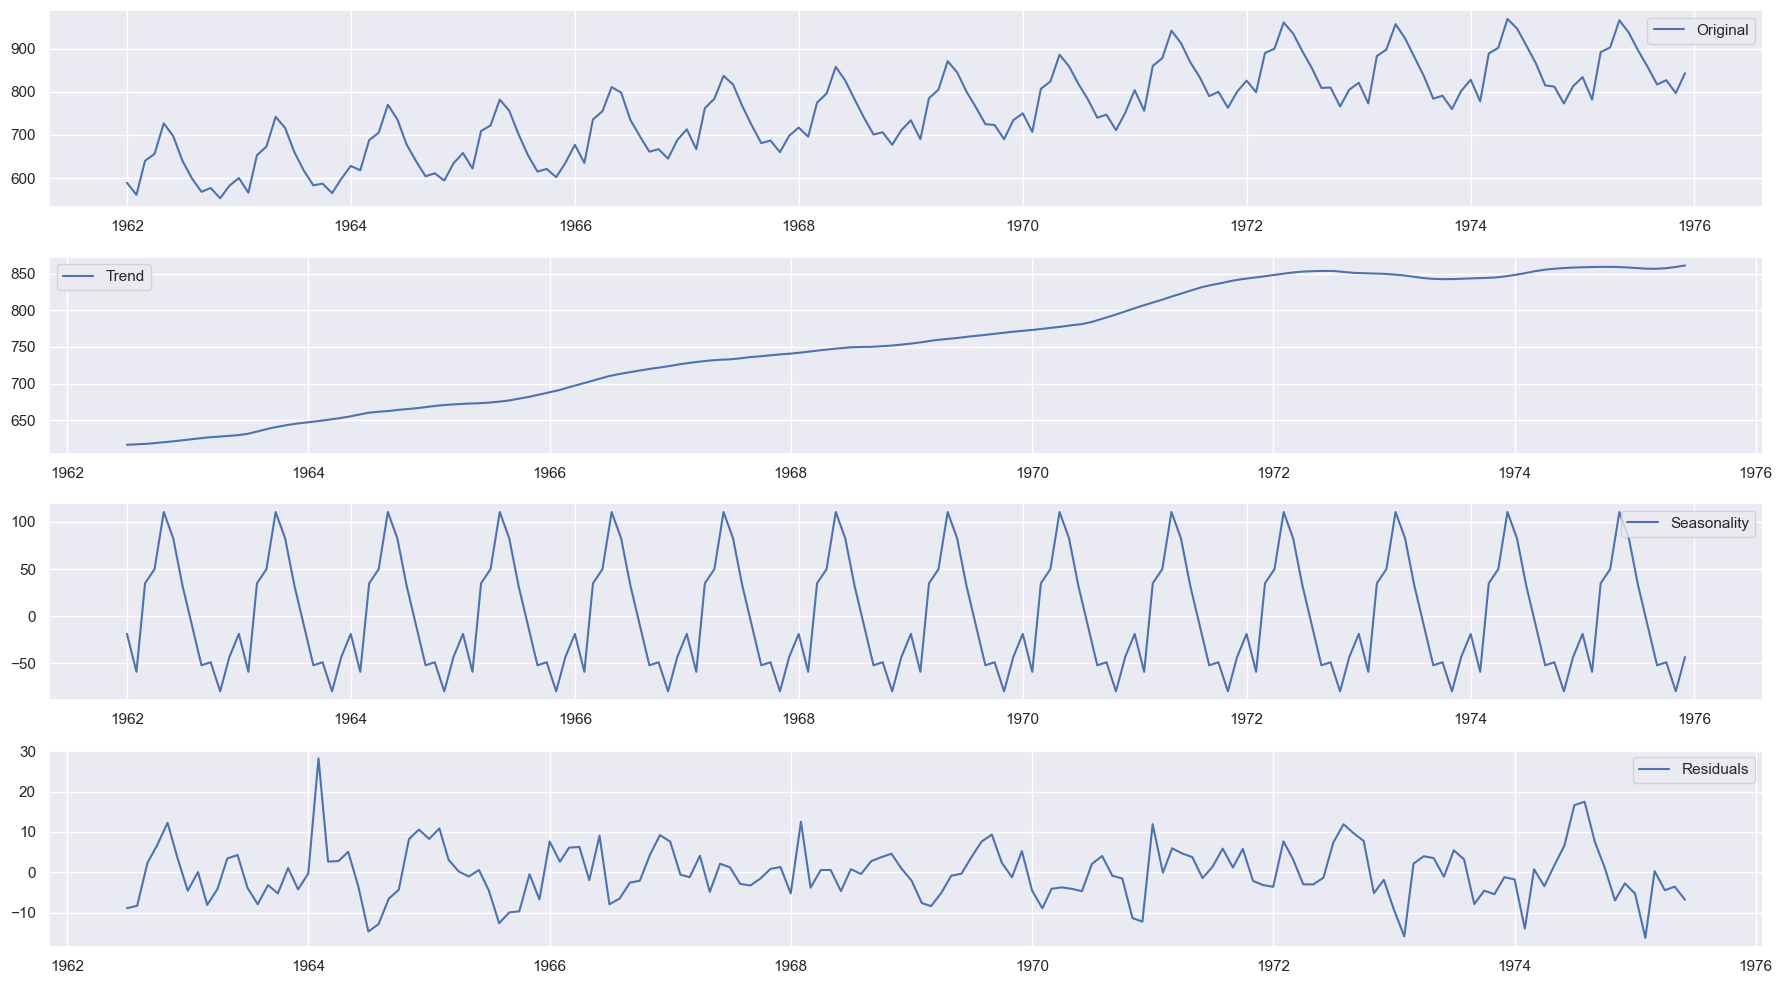

In [17]:
decomposition = seasonal_decompose(data,period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.xticks(rotation=90, ha='right')
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [18]:
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())
stepwise_model.fit(data)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1068.064, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1119.969, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1081.584, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1066.296, Time=0.17 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1114.995, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1068.030, Time=0.25 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=1067.976, Time=0.37 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1082.123, Time=0.09 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1072.280, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1067.796, Time=0.21 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1066.207, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1114.845, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1067.913, Time=0.24 sec
 ARIMA(1,1,0)(0,1,2)[12]

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [19]:
Predicted_values=stepwise_model.fittedvalues()
Predicted_values=pd.DataFrame(Predicted_values,columns=['Prediction'])

### Forecasting values for next 12 months

In [20]:
Forecasted_values=stepwise_model.predict(12)
Forecasted_values=pd.DataFrame(Forecasted_values,columns=['Prediction'])

In [21]:
Consolidated_predicted_values=pd.concat([Predicted_values,Forecasted_values],axis=0)

In [22]:
Consolidated_predicted_values.tail(15)

,Prediction
1975-10-01,817.419101
1975-11-01,788.723652
1975-12-01,835.518823
1976-01-01,865.349740
1976-02-01,818.387707
1976-03-01,925.019489
1976-04-01,938.096591
1976-05-01,1001.238547
1976-06-01,973.830260
1976-07-01,932.477681


<Axes: >

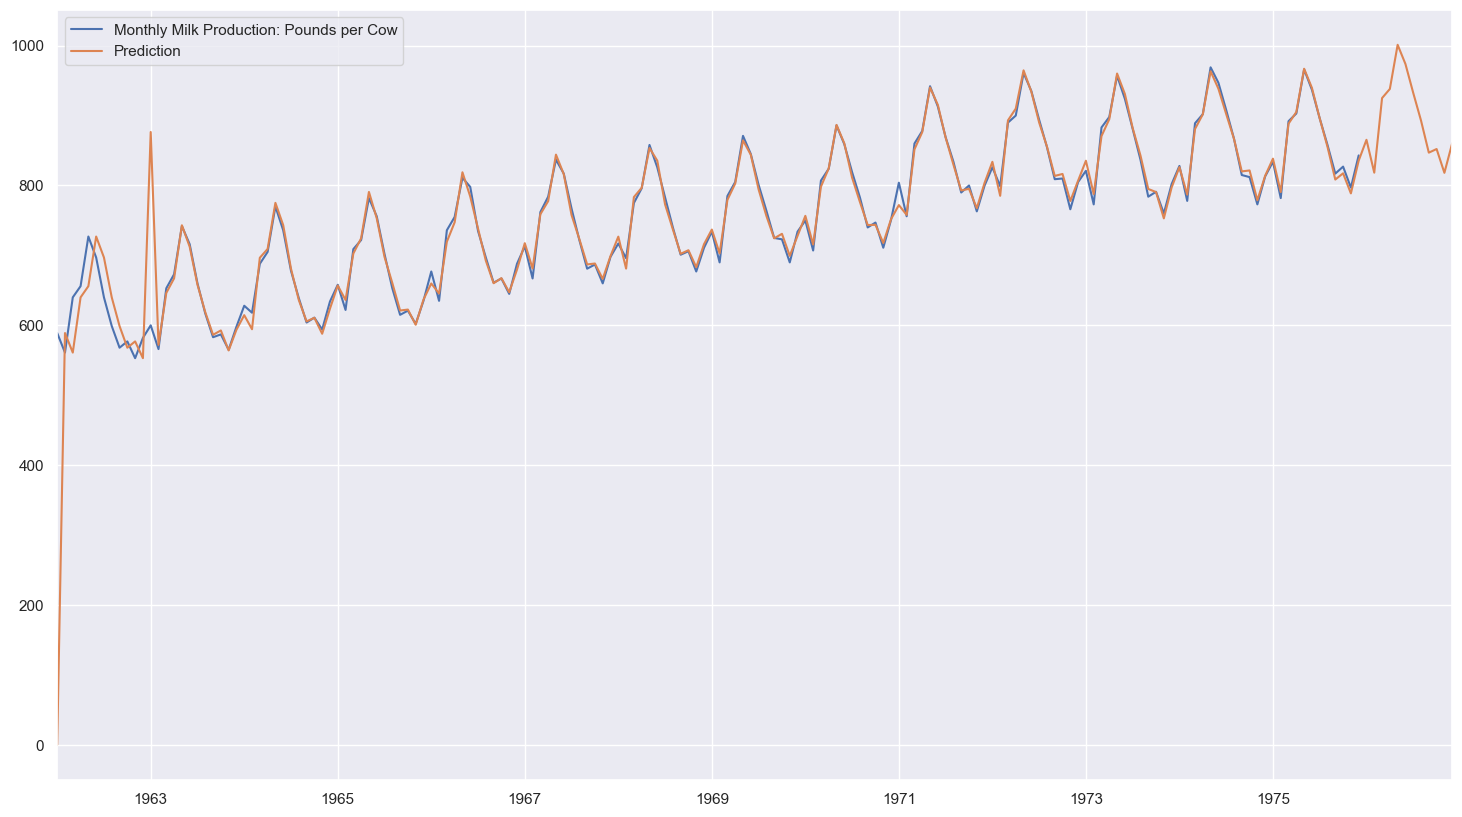

In [23]:
pd.concat([data,Consolidated_predicted_values],axis=1).plot()